In [ ]:
!pip install git+https://github.com/floringogianu/utc_mdp

  Cloning https://github.com/floringogianu/utc_mdp to /tmp/pip-req-build-8z8hvspv
  Running command git clone --filter=blob:none --quiet https://github.com/floringogianu/utc_mdp /tmp/pip-req-build-8z8hvspv
  Resolved https://github.com/floringogianu/utc_mdp to commit 1dd8ca9a8e78a5c14a4f1f7ac93865e94b19e5d0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for utc_mdp: filename=utc_mdp-0.1.0-py3-none-any.whl size=5191 sha256=4106388a2879c3021e2ac4f3f049fac603f0c837ef941bf3be1aced9d40fc48a
  Stored in directory: /tmp/pip-ephem-wheel-cache-rhajcmdp/wheels/56/47/4c/1c3199b61e3a6113fed1081141468f4c35adf36deefed10514
Successfully built utc_mdp


In [ ]:
from collections import defaultdict

import numpy as np
import torch as th

import matplotlib as mpl
import matplotlib.pyplot as plt

from utc_mdp import MDP, Sim
from utc_mdp.blueprints import FOUR_ROOMS, TWO_ROOMS

# Markov decision processes. Q-iteration and Policy Iteration.

## Lab policy

- This lab is a mandatory part of the "Reinforcement Learning" course.
The solution is graded from 0 to 10.
The average of the Python labs counts for 50% of the final grade.

- The lab is preferably solved in groups of two students (larger groups are not allowed).
  A group submits a single solution, shared between the two students.

- The solution consists of a copy of this notebook, containing your implementations and algorithm analysis.
It will be sent by email to florin.gogianu@gmail.com.

- The deadline for submitting the solution is **October 29, 2024, by 23:59**.
Late submission is accepted, but the maximum grade is reduced by half: 5 points.
The time required to complete the lab depends on experience with Python programming, but part of the work will need to be done at home.
It is strongly recommended that you do not wait until right before the deadline to finish the solution.

- Discussion of ideas between groups is encouraged, but reusing code or reports (even partially) is not allowed. Use of generative models (Chat-GPT, Gemini, Copilot, etc.) is prohibited. **Violation of this rule (copying) will result in immediate loss of the right to take the exam**.

- A discussion session will be organized where the contribution of each student will be determined through detailed technical questions, including questions related to Python implementation.

**Team members:**

Tudor Alinei-Poiana

## Short note on matrix operations in `Python` using `PyTorch`

`Python` is an open-source _general-purpose_ programming language, therefore it does not have built-in support for matrix operations.

For this purpose, the community around it developed `numpy`, a library that allows `Matlab`-like operations.

With the advent of Deep Learning, several other libraries appeared which extend `numpy` to allow for GPU computations and support for automatic differentiation.

For these labs we will use one of the more popular such libraries, called `PyTorch` or simply `torch`.

For completing this lab you are only required to know about the following:

In [ ]:
# create a tensor
a = th.zeros((2,3))
a

tensor([[0., 0., 0.],
        [0., 0., 0.]])

In [ ]:
# change a value
a[1,1] = 1
a[1,:]

tensor([0., 1., 0.])

In [ ]:
# select a value (slice operator)
a[1,1].item()

1.0

In [ ]:
# find the max value
a.max(dim=1)

torch.return_types.max(
values=tensor([0., 1.]),
indices=tensor([0, 1]))

In [ ]:
a.max(dim=1).values

tensor([0., 1.])

In [ ]:
# cast to int64
a.long()

tensor([[0, 0, 0],
        [0, 1, 0]])

## Part 1


The objective of the first part is to become familiar with the interface provided by the Python implementation of the considered problem, as well as to review the basic concepts in Markov decision processes.

See the presentation of the first course, which can be downloaded [here](https://busoniu.net/teaching/rl2024/#slides).

### Environments

The final aim of the lab is to solve problems in the environment depicted in the figure, called `GRIDNAV`:

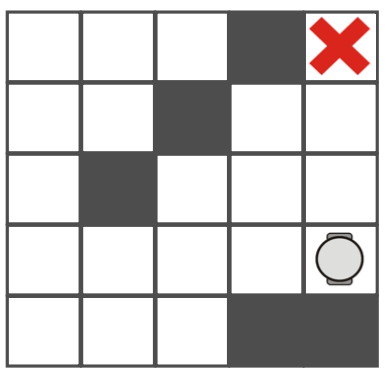

The environment is a simplification of a real robotic navigation problem.
A robot must find the shortest path to a target (red mark X), avoiding obstacles (gray squares).

The robot's position varies on a $5 \times 5$ grid, with the state $x \in \{0, ..., 19\}$ (the set of reachable states, that do not include the 5 obstacles).
Note that the state $x=0$ represents the top-left corner in the figure.

The robot can move one cell at a time in one of the four cardinal directions.
These four actions $u$ are represented by the numbers 0 (up), 1 (right), 2 (down), 3 (left).
Any movement that results in hitting a wall or obstacle fails, and the robot remains in the same cell.

The robot receives a reward of $-0.1$ at each step in which it does not reach the target, and $10$ when it reaches the target.

The target is a terminal state, so when it is reached, the episode ends, and the robot is reset to an initial position.
The negative reward represents energy consumption and leads to a minimum-time solution, i.e., a path of minimal length.

For illustration purposes and for testing your implementation we will also use the `ROOMBA` MDP, which is described in the lecture slides under the name "cleaning robot".

### Defining MDPs and working with them


Familiarize yourself with the code and the interfaces you will be required to use in order to solve the rest of the assignment.

There are two main objects in this "library":

- an `MDP` which follows the Markov Decision Process formalism and encapsulates objects such as the set of states $X$, the transition dynamics $f$, and the reward function $\rho$.
- a `Sim`, which takes an `MDP` as argument and makes out of it a _simulator_ exposing methods that make possible the agent-environment interaction loop (more on this later).

First, let's focus on the `MDP` class. It allows for easy definition of MDPs from a very simple domain specific language (DSL).

To keep things simple, remember the `ROOMBA` cleaning robot from our lectures:

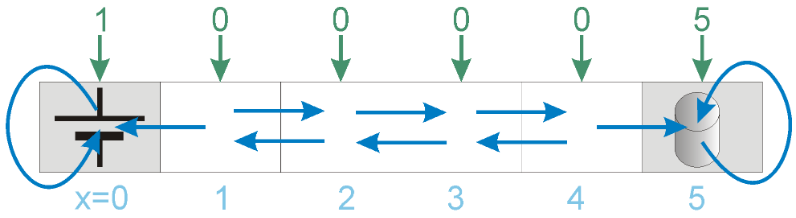

We can define this MDP using a few conventions:
- ` ` (space) indicates a state in which you can move in.
- `x` indicates an wall or obstacle.
- `s` indicates the starting state.
- uppercase letters such as `T` (trash), `B` (battery) or `G` (goal) are terminal or "absorbing" states which end the episode.
- lowercase letters other that the special tokens above indicate rewarding states.
- the line `---` separates the two sections of the DSL, the header, and the blueprint.
- the header (everything above the line) is used to define rewards as field-value pairs:
    - `x: 0.0` reward associated with bumping into walls. Usually negative.
    - `.: 0.0` reward associated with moving. Usually negative.
    - `T: 5.0` reward of 5 for picking up the trash (and restarting the episode)
    - `B: 1.0` reward of 1 for charging the battery (and restarting the episode)
- the blueprint is a string representation of the grid, containing the positions of walls and rewarding states. Its only constraint is that it needs to be fully enclosed by walls (`x`).

The DSL that defines the Cleaning Robot MDP will then look as follows:

In [ ]:
ROOMBA = """
B: 1.0
T: 5.0
x: 0.0
.: 0.0
---
xxxxxxxx
xBs   Tx
xxxxxxxx
"""

In [ ]:
mdp = MDP(ROOMBA)
mdp

xxxxxxxx
xBs   Tx
xxxxxxxx
Actions: 0: right, 1: left

#### MDP interface

- `mpd.X` return the list of reachable states $X$
- `mdp.nX` return the number of states
- `mdp.nU` return the number of actions

**For solving the tasks you are only required to know about:**
- `mdp.f(x: int, u: int) -> x': int` returns the next state `x'` when applying action `u` while in state `x`.
- `mdp.rho(x: int, u: int) -> r: float` returns the reward `r` when applying action `u` while in state `x`.
- `mdp.ρ(x: int, u: int) -> r: float` is a shorthand (alias) of `mdp.rho`

In [ ]:
# get the action-state dimensionality
print(f"#states:  {mdp.nX}")
print(f"#actions: {mdp.nU}")
print(f"states:   {mdp.X}")
print(f"actions: {mdp.U}")

#states:  6
#actions: 2
states:   [0, 1, 2, 3, 4, 5]
actions: [0, 1]


In [ ]:
for x, u in ((4, 0), (3, 1)):
    print(f"Cleaner is in state x={x} and it applies action u={u}. Arrives in next state x={mdp.f(x, u)} with reward r={mdp.rho(x, u)}")

Cleaner is in state x=4 and it applies action u=0. Arrives in next state x=5 with reward r=5.0
Cleaner is in state x=3 and it applies action u=1. Arrives in next state x=2 with reward r=0.0


#### From MDP to simulation

An `MDP` object can be used by the `Sim` object to create an environment with a simple API that facilitates the agent-environment interaction loop:

- `x, done = sim.reset()` returns the initial state and the episode termination signal. Use it to begin a new episode. `done` indicates the agent reached the goal.
- `x', r, done = sim.step(u)` receives action `u` and returns the next state, reward and episode termination signal.

In [ ]:
mdp = MDP(ROOMBA)
sim = Sim(mdp)

print(sim.reset())
print(sim.step(0))
print(sim.step(1))

(1, False)
(2, 0.0, False)
(1, 0.0, False)


### Task 1.1 [2pts]
---

**For the `GRIDNAV` MDP described above**, identify the state variables and the state space, the action variables and the action space.

Knowing that the state $x=0$ is in the upper-left corner and the data structure is in row-major order, write in the very next cell, using $\LaTeX$:

1. The transition function $f(x=10, \cdot)$ (for taking any action from state 10)
2. The reward function $\rho$.

**Solution**:

For this particular problem, the state variable is defined by the position of the robot on the 2D grid and can be represented in two possible ways:
1. Usig the pair of state variables $(x,y)$, where $x$ represents the horizontal position and $y$ represents the vertical position, with $(0,0)$ being in the top left corner;
2. using only one state variable $x$ which denotes the position of the robot on the grid $($for e.g. for a 5x5 empty grid, the value of $x$, when the robot is on the second row and third column, would be 7$)$

The discussion will be furhter developed considering the picture of the 2D grid provided in the begining of part 1 and considering the second possible representation of the state variables.

The state space $X=\{x|x<=19\}$. For the general case, in a r by c dimensional grid, the state space is  $X=\{x|x<=r⋅c-1-no_{obstacles}\}$.

The action variables define the possible moves that the agent can make from any given position: $u$.

The action space is the set of all possible actions the agent can perform from a given state and can be encoded with numbers from 0 to 3: $U=\{0,1,2,3\}$ which have (accordong to the implementation of the python package) the following meaning \{up, right, down, left\}.

1. The transition function when choosing an action from state 10 is:
            f(x=10,u)= 6, u=0,
                       9, u=3,
                       11, u=1,
                       15, u=2

2. For the reward function $ρ$, we first have to define the reward received when reaching the goal, 10, the penalty for any possible movement that does not reach the goal, -0.1, and the reward for any movement that does not change the robot's possition, 0. The reward function $ρ(x,u)$ is:
              10 if x=9 and u=0;
              -0.1 if x ∈ {4,5,7,8,10,11,12,14,15,16,17,18,19} and u=0 or
                      x ∈ {0,1,4,6,9,10,12,13,14,15,17,18} and u=1 or
                      x ∈ {0,1,4,6,7,8,9,10,11,12,13,14} and u=2 or
                      x ∈ {1,2,5,7,10,11,13,14,15,16,18,19} and u=3
              0 otherwise
            

  
          

(double click to edit this cell, `Shift+Enter` to execute it)

### Task 1.2 [1pts]
---

- Define an interesting navigation problem choosing the position of obstacles (walls), rewards and initial state.
- It should be of comparable size to the `GRIDNAV` illustrated above or larger.
- Simulate a trajectory with a policy of your choosing (pick actions manually or randomly).
- Record the number of time-steps required for the agent to reach the goal and print it.

In [ ]:
# your solution here:

GRIDNAV = """
G:10.0
x:0.0
.:-0.1
---
xxxxxxx
x     x
x xGx x
x  x  x
x  xxxx
xx    x
xxxxxxx
"""

GRIDNAV = """
G:10.0
x:0.0
.:-0.1
---
xxxxxxxx
x     xx
xx xGx x
x  x   x
x  xxxxx
xx    xx
xxxxxxxx
"""

GRIDNAV = """
G:10.0
x:0.0
.:-0.1
---
xxxxxxxxxxxx
xs    x    x
x xxx x xx x
x x   x xx x
x x x x    x
x   xGx xx x
x x x  x x x
x x xx    xx
x x     x  x
x xxx x xxxx
x     x    x
xxxxxxxxxxxx
"""

mdp=MDP(GRIDNAV)
# get the action-state dimensionality
print(f"#states:  {mdp.nX}")
print(f"#actions: {mdp.nU}")
print(f"states:   {mdp.X}")
print(f"actions:  {mdp.U}")
mdp

#(up, right, down, left)
#simulating the agent's movement, staring from x0=0 usig a manually preset policy h
sim = Sim(mdp)
sim.reset()
h=[1,1,1,1,2,2,2,2]
for u in h:
  print(sim.step(u))
#the number of steps until we reach the goal, with this policy, is 8

#using a random generated policy and starting from x0=73
GRIDNAV = """
G:10.0
x:0.0
.:-0.1
---
xxxxxxxxxxxx
x     x    x
x xxx x xx x
x x   x xx x
x x x x    x
x   xGx xx x
x x x  x x x
x x xx    xx
x x     x  x
x xxx x xxxx
x     x   sx
xxxxxxxxxxxx
"""
from random import randrange
sim = Sim(mdp)
sim.reset()
done=False
h=[1,1,1,1,2,2,2,2]
nr_random_steps=0
while not done:
  nr_random_steps+=1
  x_next, r, done=sim.step(randrange(4))
  print(f"reached state x'={x_next}, reward r={r}, ending episode signal:{done}")
print(f"Total number of random actions that were taken until reaching the goal was: {nr_random_steps}")



#states:  64
#actions: 4
states:   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
actions:  [0, 1, 2, 3]
(1, -0.1, False)
(2, -0.1, False)
(3, -0.1, False)
(4, -0.1, False)
(10, -0.1, False)
(16, -0.1, False)
(21, -0.1, False)
(29, 10.0, True)
reached state x'=9, reward r=-0.1, ending episode signal:False
reached state x'=9, reward r=0.0, ending episode signal:False
reached state x'=13, reward r=-0.1, ending episode signal:False
reached state x'=9, reward r=-0.1, ending episode signal:False
reached state x'=9, reward r=0.0, ending episode signal:False
reached state x'=9, reward r=0.0, ending episode signal:False
reached state x'=0, reward r=-0.1, ending episode signal:False
reached state x'=1, reward r=-0.1, ending episode signal:False
reached state x'=2, reward r=-0.1, ending episode sign

##  Part 2

In the second part of the lab we will implement and evaluate:

1. Q-iteration
2. Policy Iteration

You are encouraged to test your implementation on the `ROOMBA` MDP (because it's easier to understand), and then on the `GRIDNAV` MDP you defined above.

**Important:**
1. For both algorithms, you have to demonstrate your implementations are correct, by running them on the `GRIDNAV` environment, with a value of $\gamma=0.95$.
2. Visualize the resulting Q-values using `MDP.plot_values`. Visualise the resuling control law using `MDP.plot_policy`.



### Task 2.1 [3pts]
---

#### Q-iteration (value iteration with Q-values)

The algorithm has been presented in [lecture 2](https://busoniu.net/teaching/rl2024/slides_dp_handout.pdf).
The signature of the function is given below.

**Arguments:**

- the `MDP` object
- the value of `γ`
- and a default value of `1e-1` for `ε_iter`

**Returns:**
- $Q^*$, a `torch` matrix of shape $X \times U$
- number of Q-iterations

**Important:** test your implementation using the `ROOMBA` mdp.
The results should match closely the observations presented during the lecture.

In [ ]:
def q_iteration(mdp, γ, ε_iter=1e-1):

    # TODO: your implementation here
    Q = th.zeros((mdp.nX, mdp.nU))
    Q_prev=Q.clone()
    q_itt=0
    while True:
      q_itt+=1
      Q_prev=Q.clone()
      for x in mdp.X:
        for u in mdp.U:
          x_next, r=mdp.f(x, u), mdp.rho(x, u)
          Q[x,u]=r+γ*Q_prev[x_next,:].max().item()
      if th.norm(Q-Q_prev)<=ε_iter:
        break
    h=th.zeros(mdp.nX,mdp.nU)
    for x in mdp.X:
        Q_max=Q[x,:].argmax()
        #print(Q_max)
        h[x,Q_max]=1
      #print("-----")
    return Q, h,  q_itt

#### Q-iteration on ROOMBA

tensor([0.0000, 0.6250, 1.2500, 2.5000, 5.0000, 0.0000]) [0 1 2 3 4 5]
tensor([0.0000, 1.0000, 0.5000, 0.6250, 1.2500, 0.0000]) [0 1 2 3 4 5]


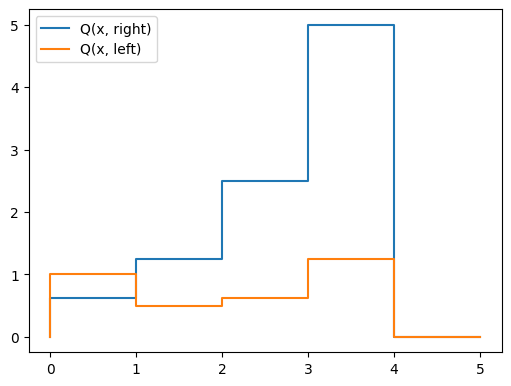

In [ ]:
# check your implementation on the ROOMBA MDP.
# It should reproduce the values from the lecture exactly.

mdp = MDP(ROOMBA)
Q, h, n = q_iteration(mdp, γ=0.5)
#print(f"{n} iterations")
#print(f"{Q} Q")
#print(f"{h} control law")
mdp.qsa_lineplot(Q)
#MDP.plot_policy(mdp, h, Q.max(1).values)

(<Figure size 640x480 with 2 Axes>, <Axes: >)

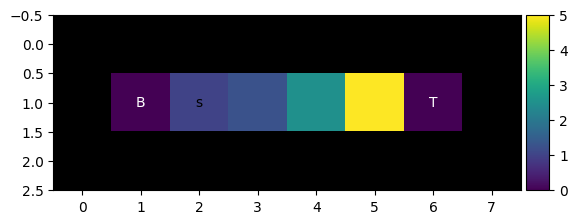

In [ ]:
MDP.plot_values(mdp, Q.max(1).values)

#### Q-iteration on GRIDNAV

If your implementation is working properly, you can now evaluate it on the larger MDP.

In [ ]:
mdp = MDP(GRIDNAV)
mdp

xxxxxxxxxxxx
x     x    x
x xxx x xx x
x x   x xx x
x x x x    x
x   xGx xx x
x x x  x x x
x x xx    xx
x x s   x  x
x xxx x xxxx
x     x    x
xxxxxxxxxxxx
Actions: 0: up, 1: right, 2: down, 3: left

Done in 14 iterations.


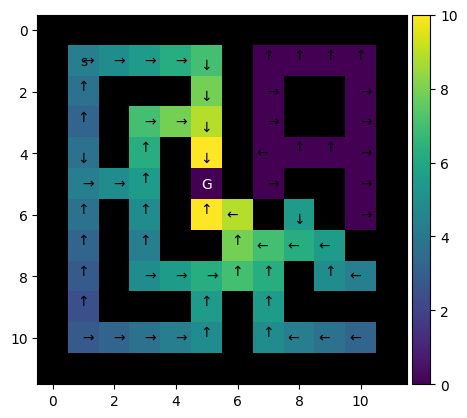

In [ ]:
Q, h, n = q_iteration(mdp, γ=0.9)
print(f"Done in {n} iterations.")
#MDP.plot_values(mdp, values=Q.max(1).values)
MDP.plot_policy(mdp, h, Q.max(1).values)

#### Policy Iteration

The algorithm has been presented in [lecture 2](https://busoniu.net/teaching/rl2024/slides_dp_handout.pdf).
The signature of the function is given below.

**Arguments**:

- the `MDP` object
- the value of `γ`
- a default value of `1e-1` for `ε_eval`
- a default value of `100` for `max_iterations`, the maximum number of policy iterations if the stoping criteria has not been met.

**Returns**:

- $h^*$, a `torch` matrix of shape $X \times U$ of type `torch.long`
- $Q^*$, a `torch` matrix of shape $X \times U$ of type `torch.float32`
- number of (major) policy iterations $\mathcal{l}$
- number of (minor) policy evaluation iterations $\tau$ for the last policy that was evaluated

In [ ]:
def policy_iteration(mdp, γ, ε_eval=1e-1, max_iterations=100):

    # TODO: your implementation here
    h = th.stack([th.eye(mdp.nU)[i] for i in th.randint(0, mdp.nU, (mdp.nX,))]).long()
    h_prev=h.clone()
    τ_list=[]
    for l in range(max_iterations):
      h_prev=h.clone()
      #policy evaluation
      Q, τ=policy_evaluation(mdp, γ, h, ε_evalq=1e-1)
      τ_list.append(τ)
      #policy improvement
      for x in mdp.X:
        Q_max=Q[x,:].argmax()
        #print(Q_max)
        h[x,:]=th.zeros(h[x,:].size())
        h[x,Q_max]=1
      #print("-----")
      if th.norm((h-h_prev)*1.0)<=ε_eval:
        break
    return h, Q, l, τ_list

def policy_evaluation(mdp, γ, h, ε_evalq=1e-1):
  Q = th.zeros((mdp.nX, mdp.nU))
  Q_prev=Q.clone()
  τ=0
  while True:
    τ+=1
    Q_prev=Q.clone()
    for x in mdp.X:
      for u in mdp.U:
        x_next = mdp.f(x, u)
        action=th.nonzero(h[x_next,:])[0].item()
        #print(action)
        #print(h)
        Q[x,u]=mdp.rho(x,u)+ γ*Q[x_next,action]
    if th.norm(Q-Q_prev)<=ε_evalq:
      #print(f"Minor iterations:{τ}")
      break
  return Q, τ


In [ ]:
mdp=MDP(GRIDNAV)
h, Q, l, τ_list = policy_iteration(mdp, 0.95)
#print(h)
print(f"Done in {l} policy iterations. Last policy evaluation took {τ_list[-1]} iterations.")

Done in 12 policy iterations. Last policy evaluation took 10 iterations.


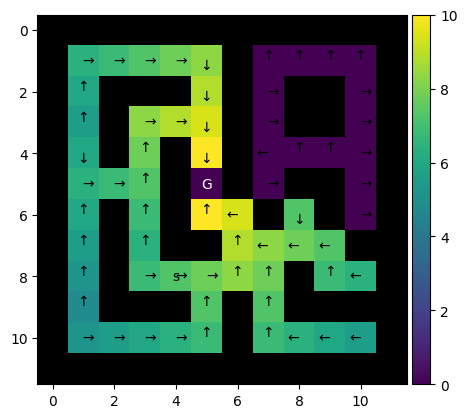

In [ ]:
MDP.plot_policy(mdp, h, Q.max(1).values)

##  Part 3

In this third and last part of the lab we will look into the behaviour of the two algorithms you implemented and the resulting solutions they produce.

### Task 3.1 [1.5pts]
---

Compare i) the number of iterations and ii) the execution time of Q-iteration with those of Policy Iteration.

For Policy Iteration, consider on the one hand the number of (major) policy iterations $l$ and the number of (minor) policy evaluation iterations $\tau$.

You can use the `%timeit your_algo(...)` command for measuring the execution time of each algorithm.

In [ ]:
#measuring time for Q-iteration
%%timeit
Q, h, n = q_iteration(mdp, γ=0.95)

176 ms ± 56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
#measuring time for Policy iteration
%%timeit
h, Q, l, τ = policy_iteration(mdp, 0.95)

3.28 s ± 690 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
print(f"Q-iteration number of iterations:{n}\n\n")
print(f"Policy iteration number of major iterations:{l+1}\nPolicy iteration number of minor iterations:{τ}")

Q-iteration number of iterations:14


Policy iteration number of major iterations:13
Policy iteration number of minor iterations:[27, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 10]


**Your results:**

For the Q-iteration, the number of iterations is 14, while for the Policy iterations, the number of major iterations is smaller, 13, but we have to take into account that for each major iteration we perform a certain number of minor iterations. The number of minor iterations is recorded at each major iteration was stored in a vector and has the following values: [27, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 10].
Overall, the total number of iterations for the Policy iteration is significantly bigger than the Q-iteration: 119 compared to 14 iterations.

The total time required for the Q-iteration to converge was about 176 miliseconds, while for the Policy iteration the average reqired time until convergence was around 3 seconds. This result was expected because, for a large Markov decission proccess, the Q-iteration avoids the full policy evaluation step and relies only on maximizing the reward, while the Policy iteration reevaluates the control law at each step by trying to improve the reward (so each major iteration will take more time due to policy evaluation).


### Task 3.2 [1.5pts]
---

Change, incrementally, the value of $\gamma$ from 0.6 to 0.99.
Execute one of the algorithms for obtaining $Q^*$ and $h^*$ for the values of $\gamma$ you experimented with.

Discuss the significance of $\gamma$ and the evolution of $Q^*$ with the value of $\gamma$.
How does the optimal control law change (why?/why not?).

**Your results:**

For larger values of $\gamma$ the Q-iteration algorithm will require more iterations to converge. This is because $\gamma$ determines how much weight is given to future rewards when calculating the reward of state-action pairs. A higher $\gamma$ places greater emphasis on long-term rewards, meaning the algorithm will optimize the reward function over a longer horizon. As a result, the Q function evolves more slowly, since changes in distant future rewards still have a greater influence on the updates. This will lead to a solution that takes into account the long-term quality of the solution.

On the other hand, when $\gamma$ is smaller, the algorithm prioritizes immediate rewards, placing less importance on future outcomes. The Q-iteration algorithm will therefore converge more quickly because updates primarily reflect the impact of immediate state-action pairs. This results in a solution that maximizes rewards over a shorter time horizon.

Considering these two aspects, the chosen value of the discount factor $\gamma$ impacts the optimal solution for the Q-function maximization problem. This also has a major effect on the resulting control policy which can vary depending on the selected value of $\gamma$.

(the above comments can be correlated with the output of the bellow code section)


In [ ]:
#In this part, we will use the Q-iteration
γ_list=th.linspace(0.66,0.99,30)
γ_list=γ_list.tolist()
#List to store the number of iterations for each gamma
n_iterations=[]
Q_list=list()
h_list=list()
for γ in γ_list:
  Q, h, n = q_iteration(mdp, γ)
  Q_list.append(Q)
  n_iterations.append(n)
  h_list.append(h)
print(n_iterations)
print("Some results on Q:")
print(Q_list[0])
print(Q_list[-1])
print(Q_list[0]<=Q_list[-1])
print("Some results on h:")
print(h_list[0])
print(h_list[-1])
print(h_list[0]==h[-1])
#The printed results from bellow have the purpose to enforce the conclusion stated above by showing
#the distinction for the resulted Q-function and policy h when using two distinct values of γ: one for
#0.66 and 0.99

[11, 11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]
Some results on Q:
tensor([[ 0.1765,  0.2674, -0.0495,  0.1765],
        [ 0.3674,  0.5567,  0.3674,  0.0765],
        [ 0.6567,  0.9950,  0.6567,  0.2674],
        [ 1.0950,  1.6592,  1.0950,  0.5567],
        [ 1.7592,  1.7592,  2.6654,  0.9950],
        [ 0.0000, -0.1000, -0.1000,  0.0000],
        [ 0.0000, -0.1000,  0.0000, -0.1000],
        [ 0.0000, -0.1000,  0.0000, -0.1000],
        [ 0.0000,  0.0000, -0.1000, -0.1000],
        [ 0.0765,  0.0505, -0.1000,  0.0505],
        [ 1.6592,  2.7654,  4.1900,  2.7654],
        [-0.1000,  0.0000, -0.1000,  0.0000],
        [-0.1000,  0.0000, -0.1000,  0.0000],
        [-0.0495,  0.0000, -0.0495,  0.0000],
        [ 1.7592,  2.6654,  0.9950,  1.7592],
        [ 2.7654,  4.1900,  2.7654,  1.6592],
        [ 2.6654,  4.2900,  6.5000,  2.6654],
        [-0.1000,  0.0000, -0.1000,  0.0000],
        [-0.1000,  0.0000, -0.10